<a href="https://colab.research.google.com/github/ritwikraha/GenerativeFill-with-Keras-and-Diffusers/blob/main/image-editing-with-text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Based Image Editing

Creating an Open Source alternative for GenerativeFill and other editing tools.

Through this notebook we aim to:

- Provide an Edit Prompt
- Provide an Image
- Edit the Image based on the initial Prompt

How do we propose to do this?

- Accept a `edit_prompt` and an `image` as inputs
- Pass the `edit_prompt` through a language model to extract source and target entities
- Use a Vision Model to `caption` the image
- Create a `replacement_caption` where the source entity of the original image is swapped with target entity in the `edit_prompt`
- Use the source entity to create a segmentation mask using Grounding Dino and SAM
- Use the mask and the `recplacement_caption` for image inpainting


## Setup and Imports

In [1]:
!pip install -qq --upgrade keras-cv tensorflow
!pip install -qq --upgrade keras
!pip install -qq --upgrade transformers
!pip install -qq --upgrade accelerate
!pip install -qq --upgrade diffusers
!pip install -qq git+https://github.com/IDEA-Research/GroundingDINO.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.1/613.1 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0.post1 requires keras<2.16,>=2.15.0, but you have keras 3.0.4 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.7/279.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 28.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os; os.environ["KERAS_BACKEND"]="tensorflow"

import keras
from keras import ops
import keras_cv

import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

import torch

from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BlipProcessor,
    BlipForConditionalGeneration,
)
from diffusers import AutoPipelineForInpainting
from groundingdino.util.inference import Model as GroundingDINO

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
!wget -q https://raw.githubusercontent.com/IDEA-Research/GroundingDINO/v0.1.0-alpha2/groundingdino/config/GroundingDINO_SwinT_OGC.py
!wget -q --output-document dog.jpeg https://i.imgur.com/CiAbKbS.jpeg

## Load the image and the edit prompt

In [5]:
def inference_resizing(image, new_shape=(1024, 1024)):
    image = ops.cast(image, dtype="float32")
    image = ops.expand_dims(image, 0)
    image = ops.image.resize(image, new_shape)[0]
    return image

In [6]:
# @title What do you want to do? { run: "auto", form-width: "100px" }
text_prompt = "replace the dog with a tiger" # @param {type:"string"}

In [7]:
image = keras.utils.load_img("dog.jpeg")
image = ops.convert_to_numpy(inference_resizing(image))

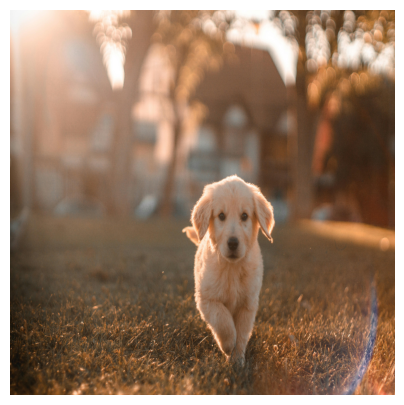

In [8]:
plt.figure(figsize=(5, 5))
plt.imshow(image.astype(np.uint8))
plt.axis("off")
plt.show()

## Extract the entities from the prompt

In [9]:
language_model_id = "Qwen/Qwen1.5-0.5B-Chat"
model = AutoModelForCausalLM.from_pretrained(
    language_model_id,
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(language_model_id)

messages = [
    {"role": "system", "content": "Follow the examples and return the expected output"},
    {"role": "user", "content": "Swap mountain and lion"},  # example 1
    {"role": "assistant", "content": "mountain, lion"},  # example 1
    {"role": "user", "content": "Change the dog with cat"},  # example 2
    {"role": "assistant", "content": "dog, cat"},  # example 2
    {"role": "user", "content": text_prompt}
]

text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to(device)

generated_ids = model.generate(
    model_inputs.input_ids,
    max_new_tokens=512
)
generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]

response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


In [10]:
to_replace, replace_with = response.split(", ")

In [11]:
print(f"{to_replace=}")
print(f"{replace_with=}")

to_replace='dog'
replace_with='tiger'


## Caption the image

A vision model BLIP: Bootstrapping Language-Image Pre-training for Unified Vision-Language Understanding and Generation is used here. BLIP performs a variety of multimodal tasks including

- Visual Question Answering
- Image-Text retrieval (Image-text matching)
- Image Captioning

We load the model from HuggingFace and pass the image to it, so that it provides a caption for us.

In [12]:
caption_model_id = "Salesforce/blip-image-captioning-base"

image_model = BlipForConditionalGeneration.from_pretrained(
    caption_model_id,
).to(device)
processor = BlipProcessor.from_pretrained(caption_model_id)

inputs = processor(image.astype("uint8"), return_tensors="pt").to(device)
outputs = image_model.generate(**inputs, max_new_tokens=200)

caption = processor.decode(outputs[0], skip_special_tokens=True)

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

### Create the replacement

Use simple string manipulation to replace the source entity with the target entity.

In [13]:
replace_caption = caption.replace(to_replace, replace_with)

In [14]:
print(f"{caption=}")
print(f"{replace_caption=}")

caption='a small dog running through a field of grass'
replace_caption='a small tiger running through a field of grass'


## Build segmentation mask

Now we focus on using the source entity to build the segmentation mask. We need a Segmentation model in our case this is SAM (Segment Anything Model) by Meta, but we also need another model that matches the text input with the object inside the image. Initially the plan was for Meta to release a text encoder for SAM.

The community is still waiting for it...

 You can check the progress [here](https://github.com/facebookresearch/segment-anything/issues/93)

 Meanwhile there are some other Open Source alternatives. Cue-call Grounding Dino.

### Grounding DINO

Grounding DINO is a zero-shot object detection model made by combining a Transformer-based DINO detector and grounded pre-training. We prompt the model with a text and an image. The model returns a bounding box if the object of the text is present in the image.

In our case we use the `to_replace` source entity as the text and the original input image as the image.

In [15]:
CONFIG_PATH = "GroundingDINO_SwinT_OGC.py"
WEIGHTS_PATH = "groundingdino_swint_ogc.pth"

grounding_dino = GroundingDINO(CONFIG_PATH, WEIGHTS_PATH)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [16]:
boxes = grounding_dino.predict_with_caption(
    image.astype(np.uint8),
    to_replace
)
boxes = np.array(boxes[0].xyxy)

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:993: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


In [17]:
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2))

def show_mask(mask, ax):
    color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

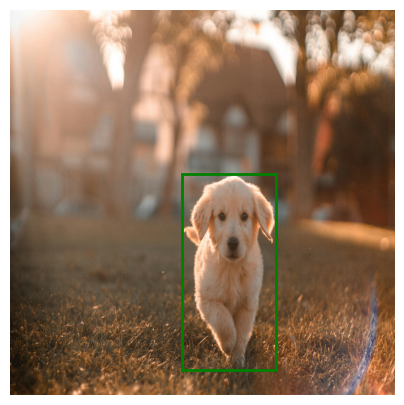

In [18]:
plt.figure(figsize=(5, 5))
plt.imshow(image.astype("uint8"))
for i in range(boxes.shape[0]):
    show_box(boxes[i], plt.gca())
plt.axis("off")
plt.show()

### SAM - Segment Anything Model

Segment Anything (SAM) is an image segmentation model developed by Meta AI. This model can identify the precise location of either specific objects in an image or every object in an image.

**Why do we need SAM?**

Because we need to create a segmentation mask for the part of the image we want to edit.

**How do we use SAM?**

In simple words SAM expects a region of the image as prompts. This can be a set of pixels, bounding-boxes or an initial mask. We already have a bounding box from Grounding Dino.

In [19]:
model = keras_cv.models.SegmentAnythingModel.from_preset("sam_base_sa1b")
outputs = model.predict(
    {
        "images": np.repeat(image[np.newaxis, ...], boxes.shape[0], axis=0),
        "boxes": boxes.reshape(-1, 1, 2, 2)
    },
    batch_size=1
)
masks = outputs["masks"][:, 0:1, ...]

100%|██████████| 3.37k/3.37k [00:00<00:00, 3.70MB/s]
100%|██████████| 358M/358M [00:23<00:00, 16.0MB/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


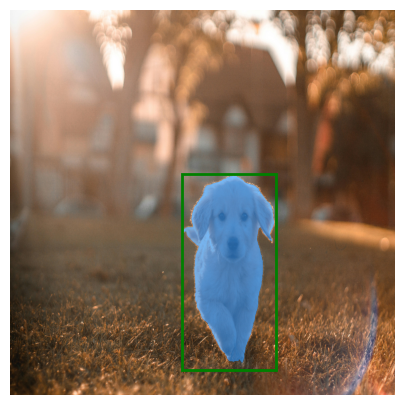

In [20]:
plt.figure(figsize=(5, 5))
plt.imshow(image.astype("uint8"))
for i in range(boxes.shape[0]):
    box = boxes[i]
    mask = masks[i, 0]
    mask = ops.convert_to_numpy(inference_resizing(mask[..., None])[..., 0]) > 0.0
    show_box(box, plt.gca())
    show_mask(mask, plt.gca())
plt.axis("off")
plt.show()

## Output

Finally we use the segmentation mask and the replaced caption to create an inpainting pipeline for image editing.

### Image Inpainting


Inpainting replaces or edits specific areas of an image. Inpainting relies on a mask to determine which regions of an image to fill in; the area to inpaint is represented by white pixels and the area to keep is represented by black pixels.

Here we use Diffusion to do this. Specifically Stable Diffusion.

TL;DR
- A Stable Diffusion model generates an image
- It does this by iteratively adding noise to an image and then removing noise to regain the original image
- In the process it learns how to remove noise
- The model that learns this can be conditioned on text
- It can also be conditioned on other types of images, like depth maps, image masks and sometimes just patches of colors.


SDXL is a larger and more powerful version of Stable Diffusion v1.5. This model can follow a two-stage model process the base model generates an image, and a refiner model takes that image and further enhances its details and quality.

In [21]:
pipeline = AutoPipelineForInpainting.from_pretrained(
    "diffusers/stable-diffusion-xl-1.0-inpainting-0.1",
    torch_dtype=torch.float16,
    variant="fp16",
)
pipeline.enable_model_cpu_offload()

model_index.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.93k [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer_2/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 37000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


In [22]:
mask = masks[0, 0]
mask = ops.convert_to_numpy(inference_resizing(mask[..., None])[..., 0]) > 0.0

prompt = f"""{replace_caption}  illuminated by soft, warm light,
in breathtakingly high detail and vivid 8K resolution. Focus on intricate textures,
subtle light and shadow interplay, and a stunning composition that draws the viewer's eye.
Capture a sense of joy and evoke a feeling of satisfaction while maintaining
realistic proportions and natural colors. Render in a realistic style
reminiscent of modern photography with a focus on artistic expression and visual harmony."""


negative_prompt = """lowres, bad anatomy, bad hands,
text, error, missing fingers, extra digit, fewer digits,
cropped, worst quality, low quality"""

output = pipeline(
    prompt=prompt,
    image=Image.fromarray(image.astype(np.uint8)),
    mask_image=Image.fromarray(mask),
    negative_prompt=negative_prompt,
    guidance_scale=7.5,
    strength=0.6
).images[0]

Token indices sequence length is longer than the specified maximum sequence length for this model (92 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['style reminiscent of modern photography with a focus on artistic expression and visual harmony.']
Token indices sequence length is longer than the specified maximum sequence length for this model (92 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['style reminiscent of modern photography with a focus on artistic expression and visual harmony.']


  0%|          | 0/30 [00:00<?, ?it/s]

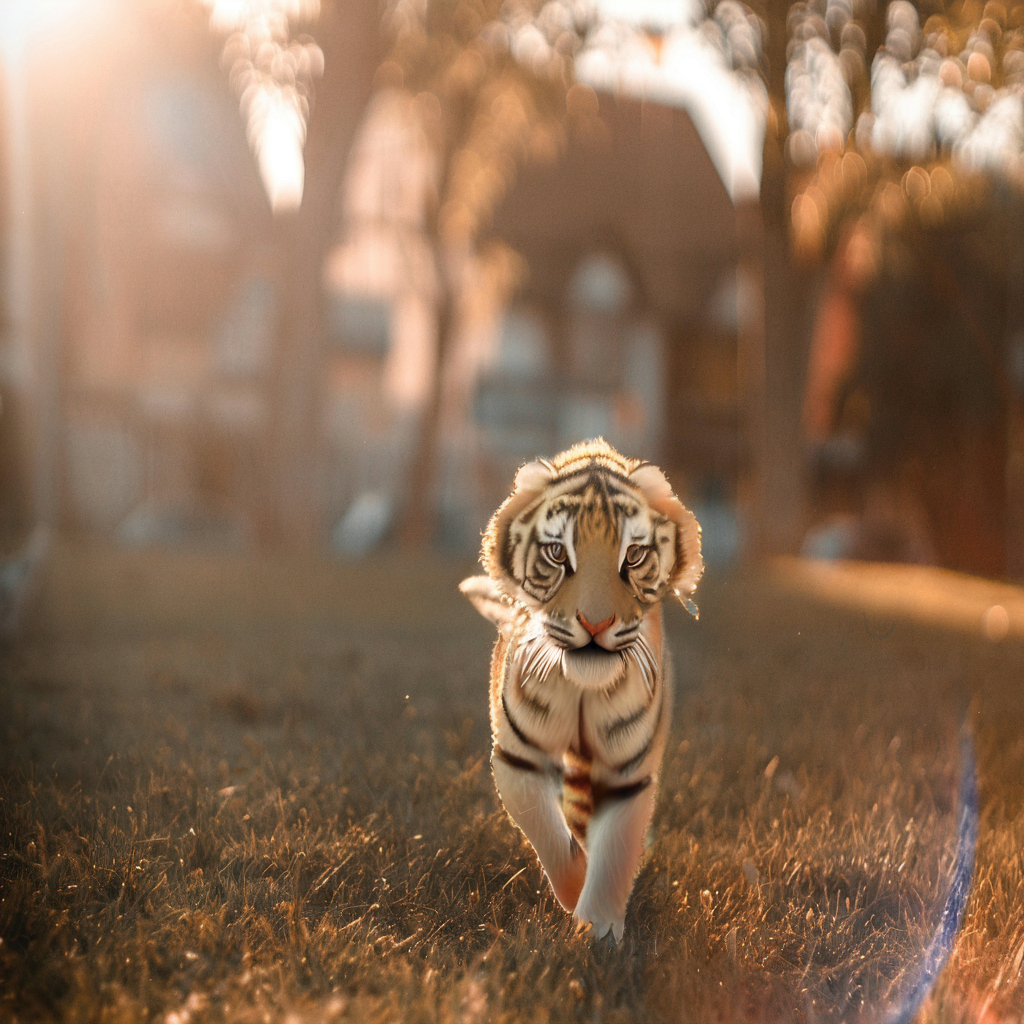

In [23]:
output